# Predicting field goals made from NBA shot logs

In [318]:
import datetime as dt
import pandas as pd 
import numpy as np 
% matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

## 1 Imports

In [319]:
data = pd.read_csv("../data/shot_logs.csv")
data.columns = data.columns.str.upper()

In [320]:
data.head(n=5)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## 2 Duplicated rows

The first thing we need to do is check the data frame for duplicated entries.

In [321]:
duplicates = data.duplicated()
total_duplicates = sum(duplicates)
print("There are %s duplicated rows in the original dataset." % total_duplicates)

There are 0 duplicated rows in the original dataset.


## 3 Duplicated features

Surprisingly there are a lot of duplicated information in our columns.

Let's start by plotting any correlations between the attributes.

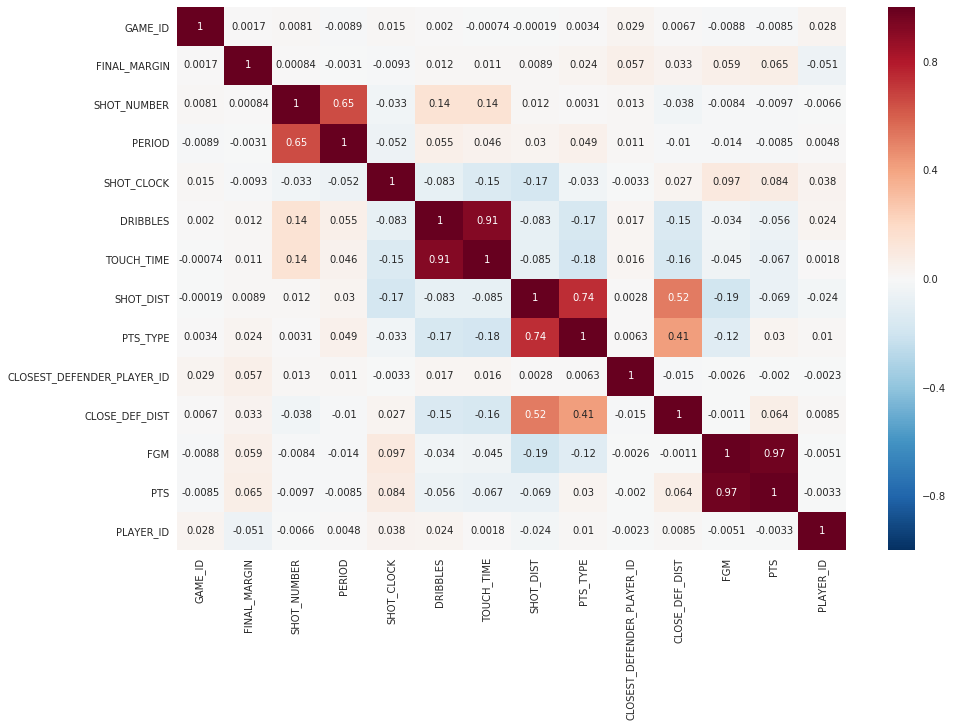

In [322]:
correlations = data.corr()
plt.rc('font', family='DejaVu Sans') 
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, annot=True)
plt.show()

In summary, we spot a bunch of features with duplicated information:
* `SHOT_NUMBER` and `PERIOD`
* `TOUCH_TIME` and `DRIBBLES`
* `SHOT_DIST` and `PTS_TYPE`
* `PTS` and `FGM`

Let's not be too smart, and address this problem by removing unnecessary columns.

We will also remove the `PLAYER_NAME` and `CLOSEST_DEFENDER` and keep the IDs and the `FGM` label and keep `SHOT_RESULT` for now.

We will remove `W` and `FINAL_MARGIN`, as those are not known to us at the moment of the shot, and the `GAME_ID`.

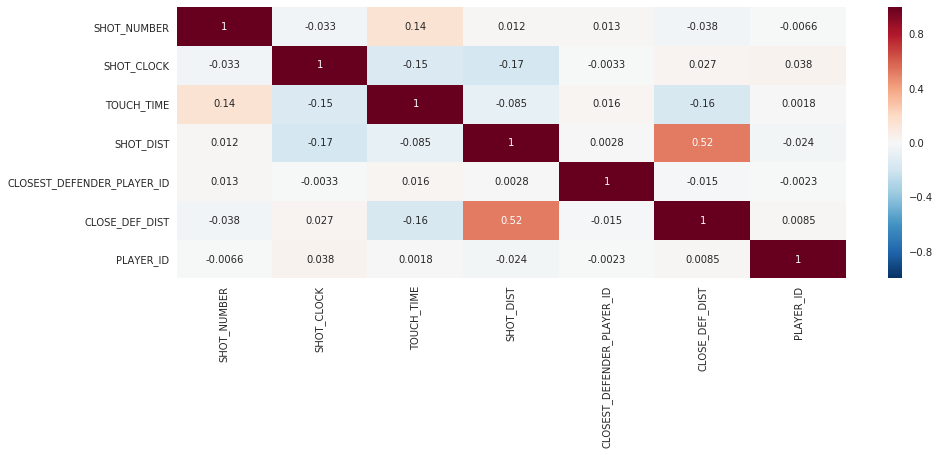

In [333]:
data_independent_features = data.drop(
    ['PERIOD', 'DRIBBLES', 'PTS_TYPE', 'PTS', 'CLOSEST_DEFENDER', 'PLAYER_NAME', 'FGM', 'W', 'FINAL_MARGIN', 'GAME_ID'], 
    axis=1)
correlations = data_independent_features.corr()
plt.rc('font', family='DejaVu Sans') 
plt.figure(figsize=(15, 5))
sns.heatmap(correlations, annot=True)
plt.show()

Things look much better now! Note that `CLOSE_DEF_DIST` (distance to the closest denfender) correlates with the `SHOT_DIST`, but we will keep both for now.

## 4 Missing values

Now we will check for missing values and deal with them.

In [334]:
missing = data_independent_features.isnull()
missing.sum()

MATCHUP                          0
LOCATION                         0
SHOT_NUMBER                      0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
TOUCH_TIME                       0
SHOT_DIST                        0
SHOT_RESULT                      0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
PLAYER_ID                        0
dtype: int64

In [335]:
total_missing = missing['SHOT_CLOCK'].sum()
total_samples = len(data_independent_features['SHOT_CLOCK'])
missing_percentage = total_missing / total_samples 
print("There are %s observations missing SHOT_CLOCK." % total_missing)
print("This represent %s of the total samples." % missing_percentage)

There are 5567 observations missing SHOT_CLOCK.
This represent 0.0434687551242 of the total samples.


For convenience, we will simply remove these observations.

In [336]:
data_complete_observations = data_independent_features.dropna()
total_missing = data_complete_observations['SHOT_CLOCK'].isnull().sum()
print("There are %s observations missing SHOT_CLOCK." % total_missing)

There are 0 observations missing SHOT_CLOCK.


## 4 Extracting features from the `MATCHUP` column

Let's take a closer look at the `MATCHUP` column.

In [337]:
data_complete_observations['MATCHUP'].head()

0    MAR 04, 2015 - CHA @ BKN
1    MAR 04, 2015 - CHA @ BKN
3    MAR 04, 2015 - CHA @ BKN
4    MAR 04, 2015 - CHA @ BKN
5    MAR 04, 2015 - CHA @ BKN
Name: MATCHUP, dtype: object

Has we can see, in the same column we have 3 features, so we have to extract them to 3 new columns:
* Date (`MATCHUP_DATE`)
* Home team (`MATCHUP_AWAY_TEAM`)
* Away team (`MATCHUP_HOME_TEAM`).

In [338]:
matchup = data_complete_observations['MATCHUP']
new_matchup_columns = matchup.str.extract(
    "(?P<MATCHUP_DATE>.{12}).{3}(?P<MATCHUP_AWAY_TEAM>.{3}).{3}(?P<MATCHUP_HOME_TEAM>.{3})", 
    expand=True)
new_matchup_columns.head(n=10)

,MATCHUP_DATE,MATCHUP_AWAY_TEAM,MATCHUP_HOME_TEAM
0,"MAR 04, 2015",CHA,BKN
1,"MAR 04, 2015",CHA,BKN
3,"MAR 04, 2015",CHA,BKN
4,"MAR 04, 2015",CHA,BKN
5,"MAR 04, 2015",CHA,BKN
6,"MAR 04, 2015",CHA,BKN
7,"MAR 04, 2015",CHA,BKN
8,"MAR 04, 2015",CHA,BKN
9,"MAR 03, 2015",CHA,. L
10,"MAR 03, 2015",CHA,. L


Apparently, there is a problem with the way we are parsing the columns, namely the `HOME_TEAM`. Let's understand why.

In [339]:
data_complete_observations['MATCHUP'][9]

'MAR 03, 2015 - CHA vs. LAL'

Apprently the string formatting is not consistent, let's tackle this.

In [340]:
matchup_clean = data_complete_observations['MATCHUP'].str.replace('vs.', '@')

Now that the problem is solve, let's extract our columns again.

In [341]:
new_matchup_columns_matchup_clean = matchup_clean.str.extract(
    "(?P<MATCHUP_DATE>.{12}).{3}(?P<MATCHUP_AWAY_TEAM>.{3}).{3}(?P<MATCHUP_HOME_TEAM>.{3})", 
    expand=True)

new_matchup_columns_matchup_clean.head(n=10)

,MATCHUP_DATE,MATCHUP_AWAY_TEAM,MATCHUP_HOME_TEAM
0,"MAR 04, 2015",CHA,BKN
1,"MAR 04, 2015",CHA,BKN
3,"MAR 04, 2015",CHA,BKN
4,"MAR 04, 2015",CHA,BKN
5,"MAR 04, 2015",CHA,BKN
6,"MAR 04, 2015",CHA,BKN
7,"MAR 04, 2015",CHA,BKN
8,"MAR 04, 2015",CHA,BKN
9,"MAR 03, 2015",CHA,LAL
10,"MAR 03, 2015",CHA,LAL


In [342]:
data_without_matchup_column = data_complete_observations.drop('MATCHUP', axis=1)
data_with_new_matchup_columns = pd.concat(
    [new_matchup_columns_matchup_clean, data_without_matchup_column], 
    axis=1)

data_with_new_matchup_columns.head(n=10)

,MATCHUP_DATE,MATCHUP_AWAY_TEAM,MATCHUP_HOME_TEAM,LOCATION,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,PLAYER_ID
0,"MAR 04, 2015",CHA,BKN,A,1,1:09,10.8,1.9,7.7,made,101187,1.3,203148
1,"MAR 04, 2015",CHA,BKN,A,2,0:14,3.4,0.8,28.2,missed,202711,6.1,203148
3,"MAR 04, 2015",CHA,BKN,A,4,11:47,10.3,1.9,17.2,missed,203900,3.4,203148
4,"MAR 04, 2015",CHA,BKN,A,5,10:34,10.9,2.7,3.7,missed,201152,1.1,203148
5,"MAR 04, 2015",CHA,BKN,A,6,8:15,9.1,4.4,18.4,missed,101114,2.6,203148
6,"MAR 04, 2015",CHA,BKN,A,7,10:15,14.5,9.0,20.7,missed,101127,6.1,203148
7,"MAR 04, 2015",CHA,BKN,A,8,8:00,3.4,2.5,3.5,made,203486,2.1,203148
8,"MAR 04, 2015",CHA,BKN,A,9,5:14,12.4,0.8,24.6,missed,202721,7.3,203148
9,"MAR 03, 2015",CHA,LAL,H,1,11:32,17.4,1.1,22.4,missed,201961,19.8,203148
10,"MAR 03, 2015",CHA,LAL,H,2,6:30,16.0,7.5,24.5,missed,202391,4.7,203148


Finally, we need to parse the matchup date.

In [343]:
matchup_date = data_with_new_matchup_columns['MATCHUP_DATE']
matchup_date = matchup_date.str.replace(" ", "")
matchup_date = matchup_date.str.replace(",", "")

data_with_new_matchup_columns_and_date = data_with_new_matchup_columns
data_with_new_matchup_columns_and_date['MATCHUP_DATE'] = pd.to_datetime(matchup_date, format='%b%d%Y')
data_with_new_matchup_columns_and_date.head()

,MATCHUP_DATE,MATCHUP_AWAY_TEAM,MATCHUP_HOME_TEAM,LOCATION,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,PLAYER_ID
0,2015-03-04,CHA,BKN,A,1,1:09,10.8,1.9,7.7,made,101187,1.3,203148
1,2015-03-04,CHA,BKN,A,2,0:14,3.4,0.8,28.2,missed,202711,6.1,203148
3,2015-03-04,CHA,BKN,A,4,11:47,10.3,1.9,17.2,missed,203900,3.4,203148
4,2015-03-04,CHA,BKN,A,5,10:34,10.9,2.7,3.7,missed,201152,1.1,203148
5,2015-03-04,CHA,BKN,A,6,8:15,9.1,4.4,18.4,missed,101114,2.6,203148


## 5 Categorical features